In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

In [3]:
from src.models.hmr import get_hmr
from src.functional.hmr import hmr_inference
def get_hmr_pretrained(ckpt_path):
    ### load hmrnet
    hmrnet = get_hmr(pretrained=True)
    ckpt = torch.load(ckpt_path, map_location="cpu")
    hmrnet.load_state_dict(ckpt["hmrnet_state_dict"])
    hmrnet.eval();
    return hmrnet

In [4]:
from src.datasets.datasets_common import UNNORMALIZE
from src.functional.smpl import get_smpl_model
from src.utils.vis_utils import render_mesh_onto_image_batch
from src.utils.vis_utils import make_square_grid

In [5]:
device = "cuda:0"
smpl_model = get_smpl_model().to(device)
smpl_model_faces = torch.tensor(smpl_model.faces.astype(int).copy()).unsqueeze(0)

# pick an experiment

In [7]:
ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"

# ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/output/train_hmr_fractional/train_hmr_frac__10/best.pth"
hmrnet = get_hmr_pretrained(ckpt)

hmrnet = hmrnet.to(device)


## inference on COCO EFT

In [8]:
from src.datasets.coco_eft import COCO_EFT
coco_eft_ds = COCO_EFT(is_train=False)

In [9]:
torch.manual_seed(0)
side = 5
batch_size = side **2
coco_eft_dl = torch.utils.data.DataLoader(coco_eft_ds, batch_size=batch_size, shuffle=True)
for sample in coco_eft_dl:
    img = sample['img']
    print(img.shape)
    break

torch.Size([25, 3, 224, 224])


Camera scale from 0.9 to 2.8


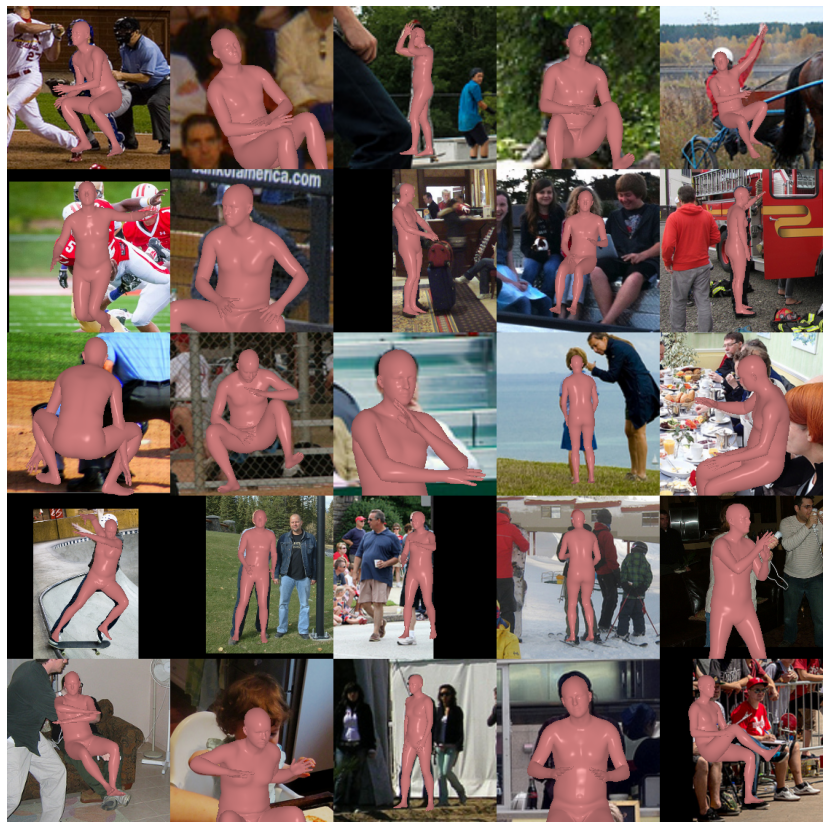

In [10]:
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)

cam_scale = out['camera'][:,0]
print(f"Camera scale from {cam_scale.min().item():.1f} to {cam_scale.max().item():.1f}")
verts3d_bbox = out['verts3d']
rendered_imgs = render_mesh_onto_image_batch(
    UNNORMALIZE(img), 
    verts3d_bbox, 
    faces=smpl_model_faces.repeat(img.size(0),1,1).to(device), 
    device=device)

rendered_imgs = make_square_grid(rendered_imgs, sq_side=side)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(rendered_imgs)
ax.set_axis_off()

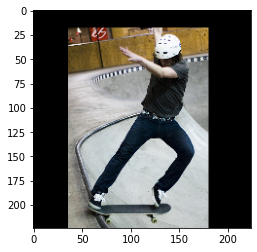

In [15]:
plt.imshow(UNNORMALIZE(img)[3].permute(1,2,0))

In [32]:
rendered_imgs = render_mesh_onto_image_batch(
    torch.zeros(1,3,1224,1224), 
    verts3d_bbox[3].unsqueeze(0)/224*1224, 
    faces=smpl_model_faces.repeat(1,1,1).to(device), 
    device=device)

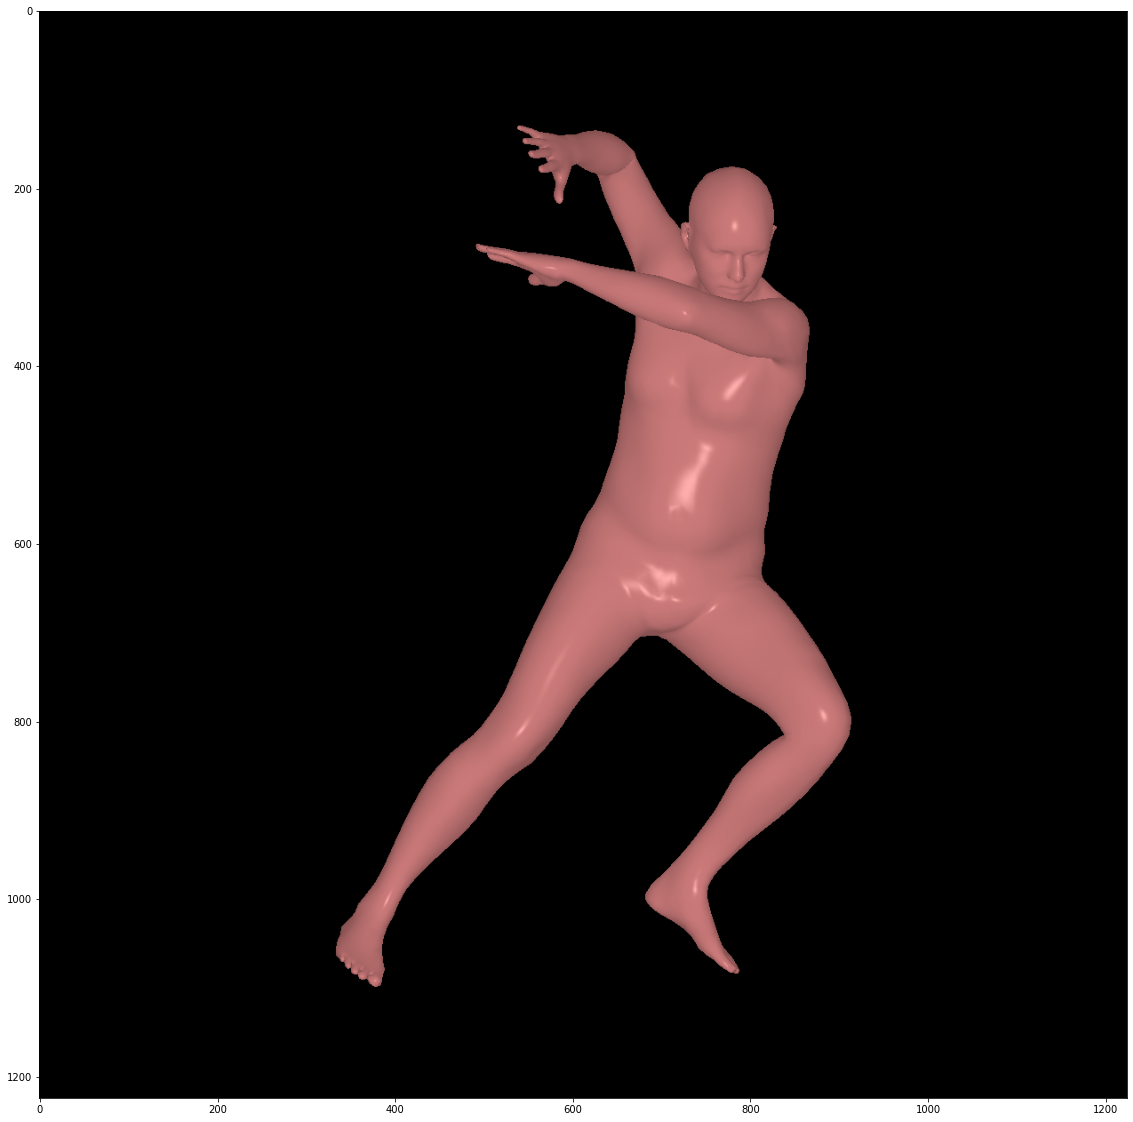

In [33]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(rendered_imgs[0])
# plt.imsave("./../rendered_imgs[0], )

In [25]:
rendered_imgs[0].shape

torch.Size([224, 224, 3])

## inference on 3DPW

In [37]:
from src.datasets.threedpw import ThreeDPW
threedpw_ds = ThreeDPW(set="test", seqlen=2, debug=True, overlap=0.)

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 17273


In [38]:
torch.manual_seed(0)
side = 5
batch_size = side **2
threedpw_dl = torch.utils.data.DataLoader(threedpw_ds, batch_size=batch_size, shuffle=True)
for sample in threedpw_dl:
    img = sample['video']
    img = img[:,0] # take only first frame in sequence
    print(img.shape)
    break

torch.Size([25, 3, 224, 224])


Camera scale from 0.7 to 1.1


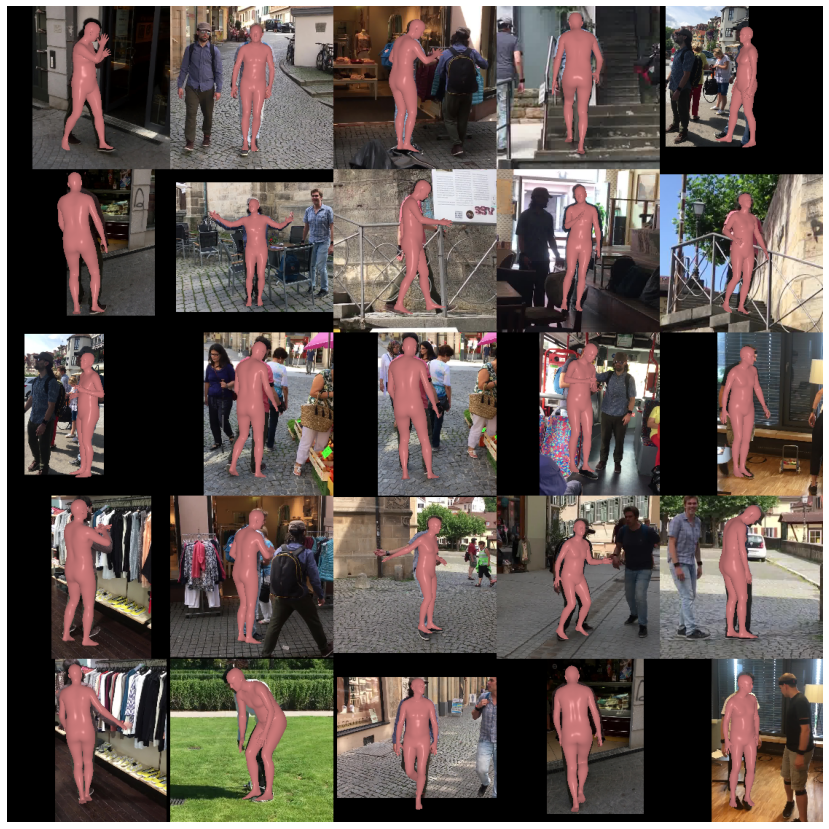

In [39]:
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)

cam_scale = out['camera'][:,0]
print(f"Camera scale from {cam_scale.min().item():.1f} to {cam_scale.max().item():.1f}")
verts3d_bbox = out['verts3d']
rendered_imgs = render_mesh_onto_image_batch(
    UNNORMALIZE(img), 
    verts3d_bbox, 
    faces=smpl_model_faces.repeat(img.size(0),1,1).to(device), 
    device=device)

rendered_imgs = make_square_grid(rendered_imgs, sq_side=side)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(rendered_imgs)
ax.set_axis_off()

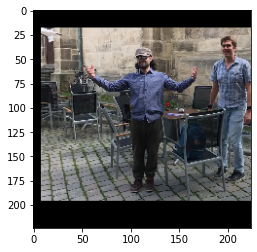

In [40]:
plt.imshow(UNNORMALIZE(img)[6].permute(1,2,0))

In [41]:
rendered_imgs = render_mesh_onto_image_batch(
    torch.zeros(1,3,1224,1224), 
    verts3d_bbox[6].unsqueeze(0)/224*1224, 
    faces=smpl_model_faces.repeat(1,1,1).to(device), 
    device=device)

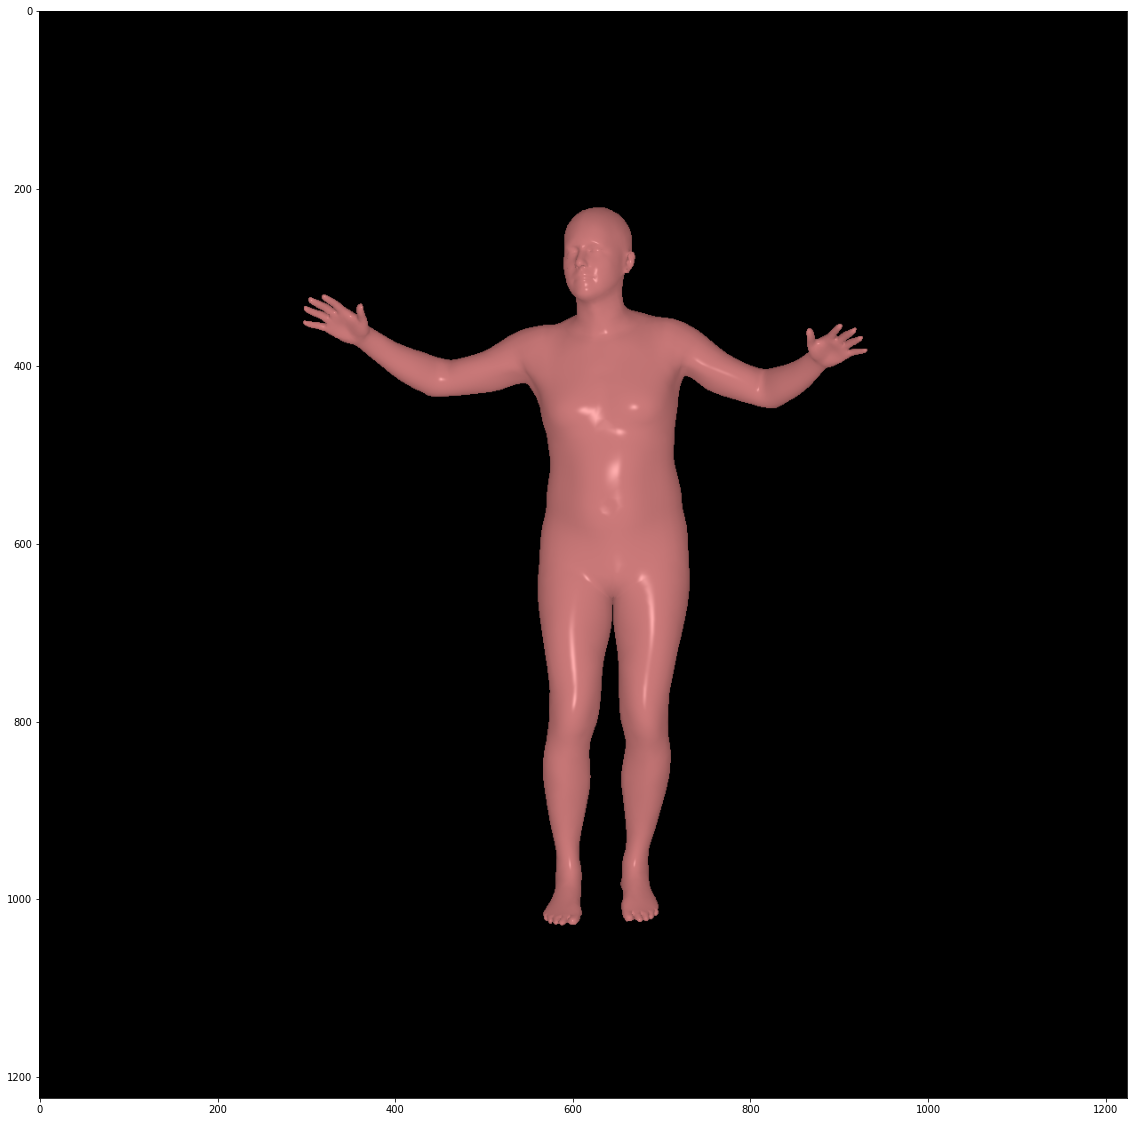

In [42]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(rendered_imgs[0])

## inference on PennAction

In [53]:
from src.datasets.pennaction import PennAction
seqlen = 2
pennaction_ds = PennAction(seqlen=seqlen)#, output_types=['video', "kp_2d", "bbox", "kp_2d_orig"])

Loaded pennaction dataset from /cvlabsrc1/cvlab/dataset_PennAction/Penn_Action/../pennaction_train_scale12_db.pt
pennaction - number of dataset objects 81343


In [166]:
torch.manual_seed(0)
side = 5
batch_size = side **2
pennaction_dl = torch.utils.data.DataLoader(pennaction_ds, batch_size=batch_size, shuffle=True)
for sample in pennaction_dl:
    img = sample['video']
    img = img[:,0] # take only first frame in sequence
    print(img.shape)
    break

torch.Size([25, 3, 224, 224])


Camera scale from 0.7 to 1.3


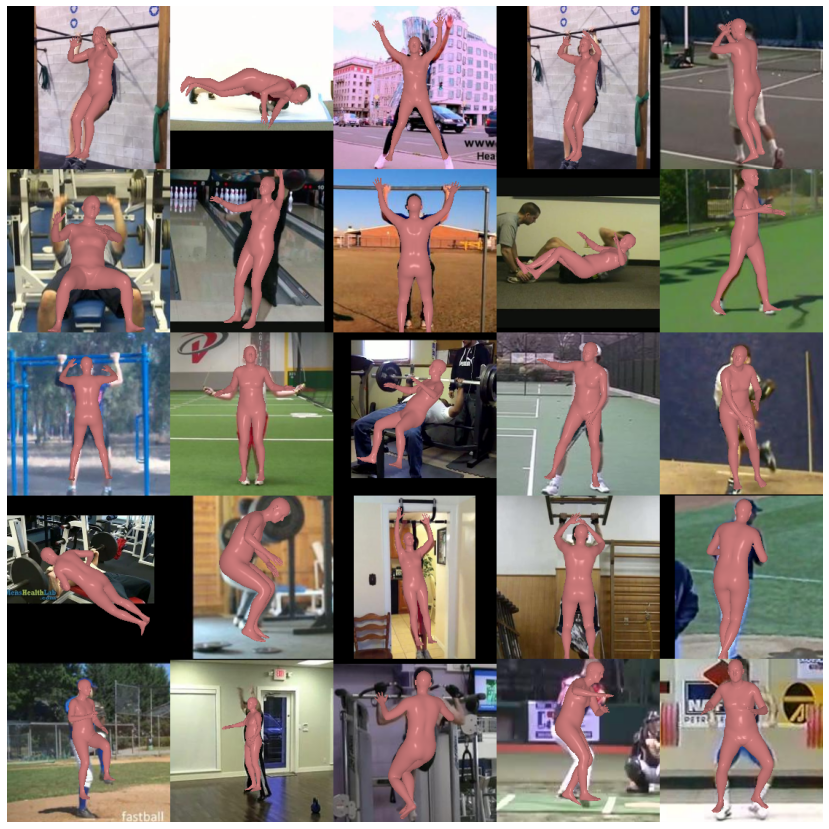

In [167]:
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)

verts3d_bbox = out['verts3d']
cam_scale = out['camera'][:,0]
print(f"Camera scale from {cam_scale.min().item():.1f} to {cam_scale.max().item():.1f}")

rendered_imgs = render_mesh_onto_image_batch(
    UNNORMALIZE(img), 
    verts3d_bbox, 
    faces=smpl_model_faces.repeat(img.size(0),1,1).to(device), 
    device=device)

rendered_imgs = make_square_grid(rendered_imgs, sq_side=side)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(rendered_imgs)
ax.set_axis_off()

## inference on H36M

In [57]:
from src.datasets.h36m import Human36M
seqlen = 2
h36m_ds = Human36M(seqlen=seqlen, set="test", debug=True, overlap=0.)

Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_test_25fps_db.pt
h36m - number of dataset objects 54386


In [169]:
torch.manual_seed(0)
side = 5
batch_size = side **2
h36m_dl = torch.utils.data.DataLoader(h36m_ds, batch_size=batch_size, shuffle=True)
for sample in h36m_dl:
    img = sample['video']
    img = img[:,0] # take only first frame in sequence
    print(img.shape)
    break

torch.Size([25, 3, 224, 224])


Camera scale from 0.7 to 1.2


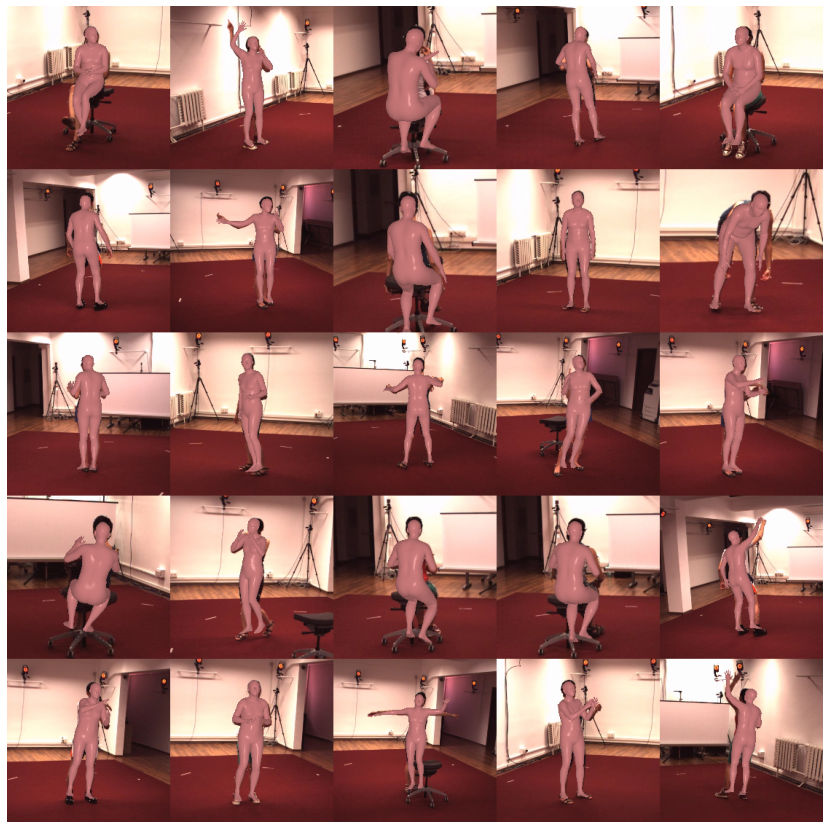

In [170]:
with torch.no_grad():
    out = hmr_inference(img.to(device), hmrnet, smpl_model)

cam_scale = out['camera'][:,0]
print(f"Camera scale from {cam_scale.min().item():.1f} to {cam_scale.max().item():.1f}")
verts3d_bbox = out['verts3d']

rendered_imgs = render_mesh_onto_image_batch(
    UNNORMALIZE(img), 
    verts3d_bbox, 
    faces=smpl_model_faces.repeat(img.size(0),1,1).to(device), 
    device=device)

rendered_imgs = make_square_grid(rendered_imgs, sq_side=side)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(rendered_imgs)
ax.set_axis_off()

# write a video 

In [11]:
from src.utils.video_utils import write_video

from src.datasets.threedpw import ThreeDPW
from src.datasets.h36m import Human36M
from src.datasets.pennaction import PennAction

In [15]:
# set up datasets
seqlen = 200

ds_dict = {}
for ds_name in ['3dpw_train', "3dpw_test", "pennaction", "h36m_train", "h36m_test"]:
    if ds_name == "3dpw_train":
        ds = ThreeDPW(set="train", seqlen=seqlen, debug=True, overlap=0.)
    elif ds_name == "3dpw_test":
        ds = ThreeDPW(set="test", seqlen=seqlen, debug=True, overlap=0.)
    elif ds_name == "pennaction":
        ds = PennAction(seqlen=seqlen, output_types=['video', "kp_2d", "bbox", "kp_2d_orig"])
    elif ds_name == "h36m_train":
        ds = Human36M(seqlen=seqlen, set="train", debug=True, overlap=0.)
    elif ds_name == "h36m_test":
        ds = Human36M(seqlen=seqlen, set="test", debug=True, overlap=0.)
    ds_dict[ds_name] = ds

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/train/3dpw_train_db.pt
3dpw - number of dataset objects 98
3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 153
Loaded pennaction dataset from /cvlabsrc1/cvlab/dataset_PennAction/Penn_Action/../pennaction_train_scale12_db.pt
pennaction - number of dataset objects 85
Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_train_25fps_db.pt
h36m - number of dataset objects 2720
Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_test_25fps_db.pt
h36m - number of dataset objects 988


In [17]:
# set_up_samples 
idx = 0
samples_dict = {}
for ds_name in tqdm(['3dpw_train', "3dpw_test", "pennaction", "h36m_train", "h36m_test"]):
    img = ds_dict[ds_name][idx]['video']
    samples_dict[ds_name] = img

100%|██████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.91s/it]


In [32]:
# ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"
# exp_name = "raw"

# ckpt = "../output/ft_w_coco_3dpw_test_seqlen2/ft_w_coco__data_1_ofc_1000_seqlen2/ckpt.pth"
# exp_name = "ft_w_3dpw_test_COCO"

# ckpt = "../output/ft_w_coco_seqlen2/ft_w_coco__3dpw_train__data_1_ofc_1000/ckpt.pth"
# exp_name = "ft_w_3dpw_train_COCO"

# ckpt = "../output/ft_w_coco_seqlen2/ft_w_coco__pennaction__data_1_ofc_100/ckpt.pth"
# exp_name = "ft_w_pennaction_COCO"

# ckpt = "../output/ft_w_coco_seqlen2/ft_w_coco__h36m_train__data_1_ofc_1000/best.pth"
# exp_name = "ft_w_h36m_train_COCO"

ckpt = "../output/ft_w_coco_seqlen2/ft_w_coco__3dpw_train_h36m_train_test__data_1_ofc_1000_halfCOCO/ckpt.pth"
exp_name = "ft_w_3dpw_h36m_all_half_coco_COCO"


hmrnet = get_hmr_pretrained(ckpt)

hmrnet = hmrnet.to(device)


/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/hub.py:704: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [33]:
import imageio

for ds_name in ['3dpw_train', "3dpw_test", "pennaction", "h36m_train", "h36m_test"]:
    img = samples_dict[ds_name]
    out_path = f"../output/rendered_gifs/{exp_name}__{ds_name}.gif"    

    rendered_imgs = []
    for img_ in tqdm(torch.split(img, 32)):
        verts3d_bbox_ = hmr_inference(img_, hmrnet, smpl_model, device)

        rendered_imgs_ = render_mesh_onto_image_batch(
            UNNORMALIZE(img_), 
            verts3d_bbox_, 
            faces=smpl_model_faces.repeat(img_.size(0),1,1), 
            device=device)
        rendered_imgs.append(rendered_imgs_)

    rendered_imgs = torch.cat(rendered_imgs)
    imageio.mimsave(out_path, (rendered_imgs.numpy() * 255).astype(np.uint8), format="GIF", fps=30)
    print(f"{ds_name}: {out_path} saved!")


100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]


3dpw_train: ../output/rendered_gifs/ft_w_3dpw_h36m_all_half_coco_COCO__3dpw_train.gif saved!


100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.18it/s]


3dpw_test: ../output/rendered_gifs/ft_w_3dpw_h36m_all_half_coco_COCO__3dpw_test.gif saved!


100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


pennaction: ../output/rendered_gifs/ft_w_3dpw_h36m_all_half_coco_COCO__pennaction.gif saved!


100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.23it/s]


h36m_train: ../output/rendered_gifs/ft_w_3dpw_h36m_all_half_coco_COCO__h36m_train.gif saved!


100%|██████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.31it/s]


h36m_test: ../output/rendered_gifs/ft_w_3dpw_h36m_all_half_coco_COCO__h36m_test.gif saved!


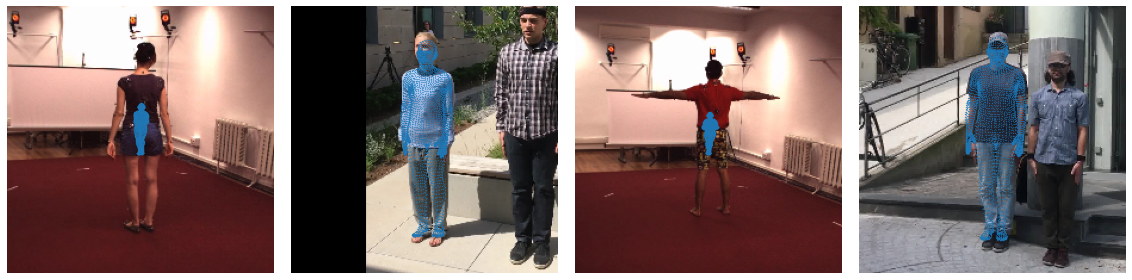

In [70]:
ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"
# ckpt = "../output/ft_w_coco_seqlen2/ft_w_coco__h36m_train__data_1_ofc_1000/ckpt_0100.pth"
ckpt = "../output/ft_w_coco_seqlen2/ft_w_coco__3dpw_train_h36m_train_test__data_1_ofc_1000/ckpt.pth"

hmrnet = get_hmr_pretrained(ckpt)
hmrnet = hmrnet.to(device)

img = torch.cat(
    (samples_dict["h36m_train"][:1],
    samples_dict["3dpw_train"][:1],
    samples_dict["h36m_test"][:1],
    samples_dict["3dpw_test"][:1],), dim=0
)
verts3d_bbox = hmr_inference(img, hmrnet, smpl_model, device)
img_orig = UNNORMALIZE(img).permute(0,2,3,1)

fig, ax = plt.subplots(1,4,figsize=(4*4,4))
for i in range(len(img)):
    ax[i].set_axis_off()
    ax[i].imshow(img_orig[i])
    ax[i].scatter(verts3d_bbox[i][:,0], verts3d_bbox[i][:,1], s=0.05)
    
fig.subplots_adjust(wspace=0.001)
fig.tight_layout()

In [ ]:
rendered_imgs = []
for img_ in tqdm(torch.split(img, 32)):
    verts3d_bbox_ = hmr_inference(img_, hmrnet, smpl_model, device)

    rendered_imgs_ = render_mesh_onto_image_batch(
        UNNORMALIZE(img_), 
        verts3d_bbox_, 
        faces=smpl_model_faces.repeat(img_.size(0),1,1), 
        device=device)
    rendered_imgs.append(rendered_imgs_)
    
rendered_imgs = torch.cat(rendered_imgs)

In [228]:
rendered_imgs = []
for img_ in tqdm(torch.split(img, 32)):
    verts3d_bbox_ = hmr_inference(img_, hmrnet, smpl_model, device)

    rendered_imgs_ = render_mesh_onto_image_batch(
        UNNORMALIZE(img_), 
        verts3d_bbox_, 
        faces=smpl_model_faces.repeat(img_.size(0),1,1), 
        device=device)
    rendered_imgs.append(rendered_imgs_)
    
rendered_imgs = torch.cat(rendered_imgs)

write_video((rendered_imgs.numpy() * 255).astype(np.uint8), out_path)

100%|████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


Video is saved to '../output/test_ft_exps/hmr_ft_3dpw_test.mp4'


In [ ]:
from src.datasets.threedpw import ThreeDPW
threedpw_ds = ThreeDPW(set="test", seqlen=16, debug=True, overlap=0.)

img = threedpw_ds[0]['video']
print(img.shape)

In [231]:
img.flatten(start_dim=0, end_dim=1).shape

torch.Size([900, 224, 224])